In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
import csv
import pandas as pd
import random
import numpy as np
from keras import regularizers
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import nltk
import itertools
from string import ascii_lowercase
from functools import reduce
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\monish\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df = pd.read_csv('stress.csv')
df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


## DATA VISUALIZATION

In [4]:
y = df['label'].values  
print(y[:5])

[1 0 1 1 1]


In [5]:
lens=df['text'].str.len()

Text(0, 0.5, 'Number of Comments')

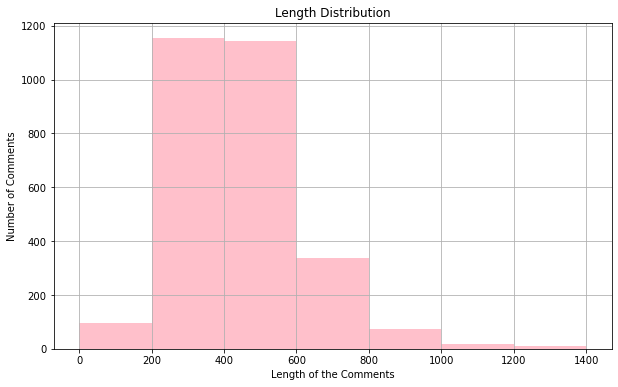

In [6]:
resize = np.arange(0, 1500,200)
lens.hist(color='pink', figsize=(10, 6), bins=resize,width=200 )
plt.title('Length Distribution')
plt.xlabel('Length of the Comments')
plt.ylabel('Number of Comments')

## DATA PRE-PROCESSING

In [7]:
# Text Normalization

RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck','fuk', 'wtf','fucck','f cking'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$'
                                                           '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'
        ],

    ' asshole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'ass hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h','beetch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' transgender':
        [
            'transgender','trans gender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k','diick '
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bullshit ':
        [
            'bullsh\*t', 'bull\$hit','bs'
        ],

    ' homosexual':
        [
            'homo sexual','homosex'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots', 'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t'
        ],

    ' shithole ':
        [
            'shythole','shit hole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumbass':
        [
            'dumb ass', 'dubass'
        ],

    ' asshead':
        [
            'butthead', 'ass head'
        ],

    ' sex ':
        [
            's3x', 'sexuality',
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' motherfucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker', 'mother fucker'
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
}

In [8]:
import re
import nltk
def clean(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 

In [9]:
train_texts = [] 
for line in tqdm_notebook(df['text'], total=2838): 
    train_texts.append(clean(line))

C:\Users\monish\AppData\Local\Temp\ipykernel_17936\1802291094.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(df['text'], total=2838):


  0%|          | 0/2838 [00:00<?, ?it/s]

In [10]:
##Lemmatization

lemmatizer= WordNetLemmatizer()
def lemma(text, lemmatization=True):
  output=''
  if lemmatization:
    text=text.split(' ')
    for word in text:
      word1 = lemmatizer.lemmatize(word, pos = "n") #noun 
      word2 = lemmatizer.lemmatize(word1, pos = "v") #verb
      word3 = lemmatizer.lemmatize(word2, pos = "a") #adjective
      word4 = lemmatizer.lemmatize(word3, pos = "r") #adverb
      output=output + " " + word4
  else:
    output=text
  
  return str(output.strip())

In [11]:
lema_train_text=[]
for line in train_texts:
    lema_train_text.append(lemma(line))

In [12]:
stopword_list=[]
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')


for letter in dual_alpha_list:
    stopword_list.append(letter)

In [13]:
print(stopword_list)
print(len(stopword_list))
print(len(lema_train_text))

['b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj', 'ak', 'al', 'ao', 'ap', 'aq', 'ar', 'au', 'av', 'aw', 'ax', 'ay', 'az', 'ba', 'bb', 'bc', 'bd', 'bf', 'bg', 'bh', 'bi', 'bj', 'bk', 'bl', 'bm', 'bn', 'bo', 'bp', 'bq', 'br', 'bs', 'bt', 'bu', 'bv', 'bw', 'bx', 'bz', 'ca', 'cb', 'cc', 'cd', 'ce', 'cf', 'cg', 'ch', 'ci', 'cj', 'ck', 'cl', 'cm', 'cn', 'co', 'cp', 'cq', 'cr', 'cs', 'ct', 'cu', 'cv', 'cw', 'cx', 'cy', 'cz', 'da', 'db', 'dc', 'dd', 'de', 'df', 'dg', 'dh', 'di', 'dj', 'dk', 'dl', 'dm', 'dn', 'dp', 'dq', 'dr', 'ds', 'dt', 'du', 'dv', 'dw', 'dx', 'dy', 'dz', 'ea', 'eb', 'ec', 'ed', 'ee', 'ef', 'eg', 'eh', 'ei', 'ej', 'ek', 'el', 'em', 'en', 'eo', 'ep', 'eq', 'er', 'es', 'et', 'eu', 'ev', 'ew', 'ex', 'ey', 'ez', 'fa', 'fb', 'fc', 'fd', 'fe', 'ff', 'fg', 'fh', 'fi', 'fj', 'fk', 'fl', 'fm', 'fn', 'fo', 'fp', 'fq', 'fr', 'fs', 'ft', 'fu', 'fv', 'fw', 'fx

In [14]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data
  return str(output.strip())

potential_stopwords = []
for line in tqdm_notebook(lema_train_text, total=2838):
    potential_stopwords.append(search_stopwords(line))
print(len(potential_stopwords))

def string_combine_a(stopword):
  final_a=""
  for item in range(0,500):
        if item >= 0 and item < len(stopword):
            final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(500,1000):
         if item >= 0 and item < len(stopword):
                final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(1000,2000):
         if item >= 0 and item < len(stopword):
                final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(2000,2838):
         if item >= 0 and item < len(stopword):
                final_d=final_d+" "+stopword[item]
  return final_d

total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    return counts

total_string_potential_a_dict=word_count(total_string_potential_a)
total_string_potential_b_dict=word_count(total_string_potential_b)
total_string_potential_c_dict=word_count(total_string_potential_c)
total_string_potential_d_dict=word_count(total_string_potential_d)

total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

C:\Users\monish\AppData\Local\Temp\ipykernel_17936\2276469346.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(lema_train_text, total=2838):


  0%|          | 0/2838 [00:00<?, ?it/s]

2838


In [15]:
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))
print(common_potential_stopwords)

['at', 'be', 'time', 'all', 'if', 'when', 'he', 'of', 'so', 'don', 'think', 'not', 'the', 'her', 'you', 'just', 'feel', 'get', 'go', 'that', 'she', 'for', 'can', 'but', 'what', 'like', 'have', 'a', 'in', 'because', 'me', 'to', 'with', 'and', 'do', 'this', 'know', 'want', 'up', 'or', 'we', 'my', 'on', 'i', 'out', 'about', 'him']


In [16]:
#Retaining certain words and removing others from the above list.
potential_stopwords=['the', 'and', 'to', 'be', 'you', 'when', 'can', 'think','up', 'time', 'or', 'if', 'for', 'know', 'we','all', 'that', 'so', 'do', 'at', 'him', 'have','get','just', 'he', 'want', 'in', 'this', 'i', 'she', 'about', 'with', 'me', 'go', 'my', 'because', 'of', 'her', 'on', 'a']

#Adding above retrived words into the stopwords list.
for word in potential_stopwords:
    stopword_list.append(word)

In [17]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())

#Removing Stopwords from Train Data
processed_train_data = [] 
for line in tqdm_notebook(lema_train_text, total=2838): 
    processed_train_data.append(remove_stopwords(line))

C:\Users\monish\AppData\Local\Temp\ipykernel_17936\3727332199.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(lema_train_text, total=2838):


  0%|          | 0/2838 [00:00<?, ?it/s]

In [18]:
processed_train_data[:5]

['say not felt way before suggeted rest trigger ahead youi hypocondriac like decide look feel doom hope maybe suck into some rabbit hole ludicrous conspiracy stupid psychic test new age something could even laugh down road no end read sense doom indicative various health ailment one which prone top doom gloom now worry heart happen physical hour',
 'hey there assistance not sure right place post but here currently student intern sandia national bullshit work survey help improve our market outreach effort many school recruit around country look current undergrad grad stem student stem student stem student would greatly appreciate help take pas along short survey thank everyone who help take survey will enter draw chance win one three amazon',
 'mom then hit newspaper shock would don like play hit smack strike hit violence any sort person send out vibe ask from universe then yesterday decide take friend help another friend move new place while drive friend move strike shoulder address im

In [19]:
max_features=7886
maxpadlen = 500    
val_split = 0.2      
embedding_dim_fasttext = 300

#Tokenization
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)

In [20]:
word_index=tokenizer.word_index
print(len(word_index))

7886


In [21]:
training_padded=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')

In [22]:
print('Tokenized sentences: \n', training_padded[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [ 164   84 1186   61   78 1245 1465  236   51   85 3399   54 3400 3399
   67   95    1 1186   16  319   44  552    3  296   45   56 1564  192
 2792 3401  768 1246    2 2178   57   96  244 4508  186 3402  655  809
 4509   59 1820  750  123   57  163  391   81   39  751 1186   44  244
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    

In [23]:
x_train, x_val, y_train, y_val = train_test_split(training_padded, y, test_size=0.2, random_state=2)

In [24]:
y_val

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,

In [25]:
x_val

array([[1011,   12,  340, ...,    0,    0,    0],
       [2974,   24, 4165, ...,    0,    0,    0],
       [ 249, 1353,    6, ...,    0,    0,    0],
       ...,
       [ 412,  168, 4323, ...,    0,    0,    0],
       [  68, 5803,   41, ...,    0,    0,    0],
       [1858,   40,   93, ...,    0,    0,    0]])

In [26]:
print('Number of entries in each category: ')
print('Training: ', y_train.sum(axis=0))
print('Validation: ', y_val.sum(axis=0))

Number of entries in each category: 
Training:  1197
Validation:  291


In [27]:
embeddings_index_fasttext = {}
f = open('wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    line.encode('utf-8').strip()
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector

In [28]:
print(type(x_train))
print(type(x_val))
print(type(y_train))
print(type(y_val))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [29]:
x_val.ndim

2

In [30]:
print(x_train.shape)
print(y_train.shape)
print(y_val.shape)
print(x_val.shape)

(2270, 500)
(2270,)
(568,)
(568, 500)


## MODEL TRAINING ( LSTM )

In [31]:
model_1 = tf.keras.Sequential([
	tf.keras.layers.Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings'),
  tf.keras.layers.Input(shape=(maxpadlen, ),dtype='int32'),
  tf.keras.layers.LSTM(40,return_sequences=True, name='lstm_layer'),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dropout(.1),
  tf.keras.layers.Dense(30, activation='relu', kernel_initializer='he_uniform'),
	tf.keras.layers.Dropout(.1),
	tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_uniform')
])
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 500, 300)          2366100   
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 lstm_layer (LSTM)           (None, 500, 40)           54560     
                                                                 
 global_max_pooling1d (Globa  (None, 40)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 30)                1230      
                                                        

In [32]:
history_1 = model_1.fit(x_train,y_train, epochs=25, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/25
71/71 [==============================] - 29s 368ms/step - loss: 0.6964 - accuracy: 0.5260 - val_loss: 0.6682 - val_accuracy: 0.5493
Epoch 2/25
71/71 [==============================] - 27s 379ms/step - loss: 0.6220 - accuracy: 0.6700 - val_loss: 0.5741 - val_accuracy: 0.7025
Epoch 3/25
71/71 [==============================] - 26s 368ms/step - loss: 0.5414 - accuracy: 0.7379 - val_loss: 0.5386 - val_accuracy: 0.7165
Epoch 4/25
71/71 [==============================] - 25s 353ms/step - loss: 0.5132 - accuracy: 0.7489 - val_loss: 0.5342 - val_accuracy: 0.7236
Epoch 5/25
71/71 [==============================] - 26s 361ms/step - loss: 0.4861 - accuracy: 0.7612 - val_loss: 0.5433 - val_accuracy: 0.7289
Epoch 6/25
71/71 [==============================] - 24s 343ms/step - loss: 0.4716 - accuracy: 0.7811 - val_loss: 0.5143 - val_accuracy: 0.7465
Epoch 7/25
71/71 [==============================] - 24s 337ms/step - loss: 0.4427 - accuracy: 0.7903 - val_loss: 0.5090 - val_accuracy: 0.7377

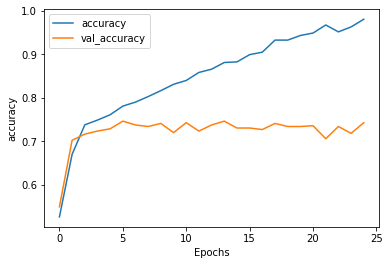

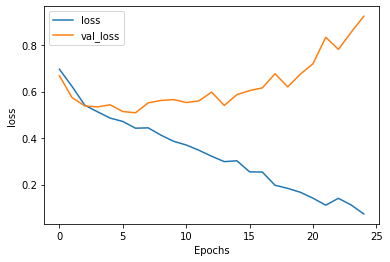

In [33]:
def plot_graphs(history_1, string):
  plt.plot(history_1.history[string])
  plt.plot(history_1.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_1, 'accuracy')
plot_graphs(history_1, 'loss')